<a href="https://colab.research.google.com/github/goswamiprashant/GANs/blob/main/CycleGan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3>Downloading data from Kaggle</h3>

In [ ]:
!pip install -q kaggle                  
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d jessicali9530/celeba-dataset

kaggle.json
 99% 1.31G/1.33G [00:10<00:00, 104MB/s]
100% 1.33G/1.33G [00:10<00:00, 137MB/s]


In [ ]:
!unzip "/content/celeba-dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: img_align_celeba/img_align_celeba/197604.jpg  
  inflating: img_align_celeba/img_align_celeba/197605.jpg  
  inflating: img_align_celeba/img_align_celeba/197606.jpg  
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align_celeba/img_align_celeba/19

<h3>Loading Libraries </h3>

In [ ]:
from keras import Input
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from keras.models import Model
#from keras.optimizers import RMSprop
from PIL import Image
from tqdm import tqdm
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt

In [ ]:
diff, ORIG_WIDTH, ORIG_HEIGHT - diff

(15, 178, 193)

100%|██████████| 10000/10000 [00:19<00:00, 515.84it/s]


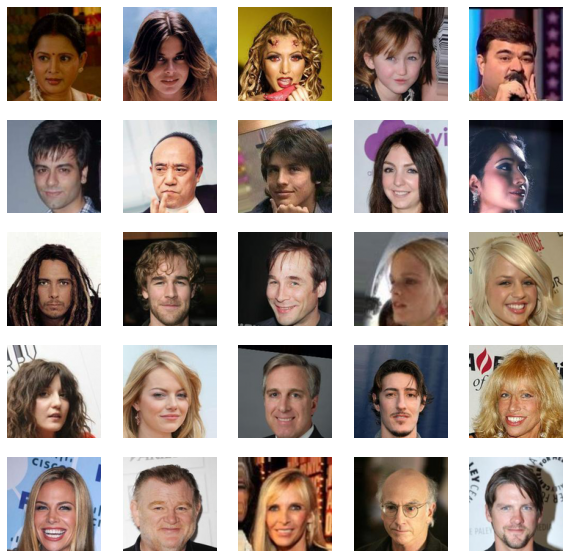

In [ ]:
PIC_DIR = '/content/img_align_celeba/img_align_celeba/'  #dir where dataset is stored 
IMAGES_COUNT = 10000
ORIG_WIDTH = 178                                         # orignal width of Image
ORIG_HEIGHT = 208                                        # orignal height of Image
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2 
WIDTH = 128                #new width
HEIGHT = 128                #new height
crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)   #cropping Image
images = []
for pic_file in tqdm(os.listdir(PIC_DIR)[:IMAGES_COUNT]):
    pic = Image.open(PIC_DIR + pic_file).crop(crop_rect)
    pic.thumbnail((WIDTH, HEIGHT), Image.ANTIALIAS)   # modifies the image to contain a thumbnail version of itself, no larger than the given size.
    images.append(np.uint8(pic)) #Normalize the images
images = np.array(images) / 255
images.shape #print first 25 images
plt.figure(1, figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

<h3>Generator </h3>

In [ ]:
LATENT_DIM = 32
CHANNELS = 3
def create_generator():
    gen_input = Input(shape=(LATENT_DIM, ))       
    
    x = Dense(128 * 16 * 16)(gen_input)             #dense layer
    x = LeakyReLU()(x)                               #leaky relu activation
    x = Reshape((16, 16, 128))(x)
    
    x = Conv2D(256, 5, padding='same')(x)        #conv layer
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)  #transpose conv layer
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)
    
    generator = Model(gen_input, x)
    generator.summary()
    return generator

In [ ]:
create_generator()  #output shape =(128,128,3)

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 32)]              0         
_________________________________________________________________
dense_8 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_48 (LeakyReLU)   (None, 32768)             0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_49 (LeakyReLU)   (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 32, 32, 256)       104

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
def create_discriminator():  #CNN based discriminator
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))
    
    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Flatten()(x)
    x = Dropout(0.4)(x)
    
    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)
    
    optimizer = tf.keras.optimizers.RMSprop(lr=.0001,clipvalue=1.0,decay=1e-8)
    
    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )
    
    return discriminator


In [ ]:
gan.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 32)]              0         
_________________________________________________________________
model_7 (Functional)         (None, 128, 128, 3)       14953987  
_________________________________________________________________
model_8 (Functional)         (None, 1)                 4211713   
Total params: 19,165,700
Trainable params: 14,953,987
Non-trainable params: 4,211,713
_________________________________________________________________


In [ ]:
generator = create_generator()             #creating generator
discriminator = create_discriminator()     #creating discriminator
discriminator.trainable = False            #Fixing disciminator parameters 
gan_input = Input(shape=(LATENT_DIM, ))    #input foe gan
gan_output = discriminator(generator(gan_input)) #output for gan
gan = Model(gan_input, gan_output)#Adversarial Model  
optimizer = tf.keras.optimizers.RMSprop(lr=.0001,clipvalue=1.0,decay=1e-8)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))]) #labeling generated 
labels += .05 * np.random.random(labels.shape)

In [ ]:
labels

array([[1.03426256],
       [1.01533911],
       [1.04135758],
       [1.04217304],
       [1.0043899 ],
       [1.01697352],
       [1.01085507],
       [1.029871  ],
       [1.03247964],
       [1.03833736],
       [1.00078644],
       [1.03210581],
       [1.0473857 ],
       [1.00669106],
       [1.03806522],
       [1.01708493],
       [0.04707072],
       [0.02185959],
       [0.03682645],
       [0.02739467],
       [0.04852218],
       [0.01027548],
       [0.02582816],
       [0.04785306],
       [0.03951722],
       [0.04415186],
       [0.01405756],
       [0.02977128],
       [0.00260101],
       [0.01794145],
       [0.02204277],
       [0.03094937]])

In [ ]:
import time

In [ ]:

iters = 100
batch_size = 16
RES_DIR = 'res2'
FILE_PATH = '%s/generated_%d.png'
if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)
CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2
start = 0
d_losses = []
a_losses = []
images_saved = 0
for step in range(iters):
    start_time = time.time()
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))  #16 * 32
    generated = generator.predict(latent_vectors)   #generated output from generator
    
    real = images[start:start + batch_size]                    #batch of real images
    combined_images = np.concatenate([generated, real])        #combined generated and real images 
    
    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))]) #labeling generated 
    labels += .05 * np.random.random(labels.shape)
    
    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)
    
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    misleading_targets = np.zeros((batch_size, 1))
    
    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)
    
    start += batch_size
    if start > images.shape[0] - batch_size:
        start = 0
    
    if step % 10 == 0:
        gan.save_weights('gan.h5')
        
        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))
        
        control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
        control_generated = generator.predict(control_vectors)
        for i in range(CONTROL_SIZE_SQRT ** 2):
            x_off = i % CONTROL_SIZE_SQRT
            y_off = i // CONTROL_SIZE_SQRT
            control_image[x_off * WIDTH:(x_off + 1) * WIDTH, y_off * HEIGHT:(y_off + 1) * HEIGHT, :] = control_generated[i, :, :, :]
        im = Image.fromarray(np.uint8(control_image * 255))
        im.save(FILE_PATH % (RES_DIR, images_saved))
        images_saved += 1

1/100: d_loss: 0.5764,  a_loss: 0.6724.  (4.4 sec)
11/100: d_loss: 0.5946,  a_loss: 0.5533.  (4.3 sec)
21/100: d_loss: 0.5833,  a_loss: 1.4223.  (4.3 sec)
31/100: d_loss: 0.5314,  a_loss: 0.6663.  (4.3 sec)
41/100: d_loss: 0.6396,  a_loss: 0.8251.  (4.9 sec)
51/100: d_loss: 0.7396,  a_loss: 0.9514.  (4.3 sec)
61/100: d_loss: 0.6297,  a_loss: 0.7935.  (4.3 sec)
71/100: d_loss: 0.6854,  a_loss: 0.9630.  (4.4 sec)
81/100: d_loss: 0.6623,  a_loss: 0.9053.  (4.3 sec)
91/100: d_loss: 0.6359,  a_loss: 0.7933.  (5.3 sec)


In [ ]:
import imageio
import shutil
images_to_gif = []
for filename in os.listdir(RES_DIR):
    images_to_gif.append(imageio.imread(RES_DIR + '/' + filename))
imageio.mimsave('trainnig_visual.gif', images_to_gif)
shutil.rmtree(RES_DIR)

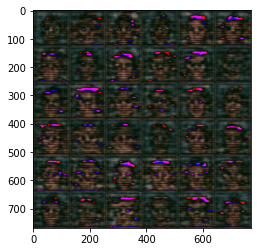

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('trainnig_visual.gif')
plt.imshow(img)

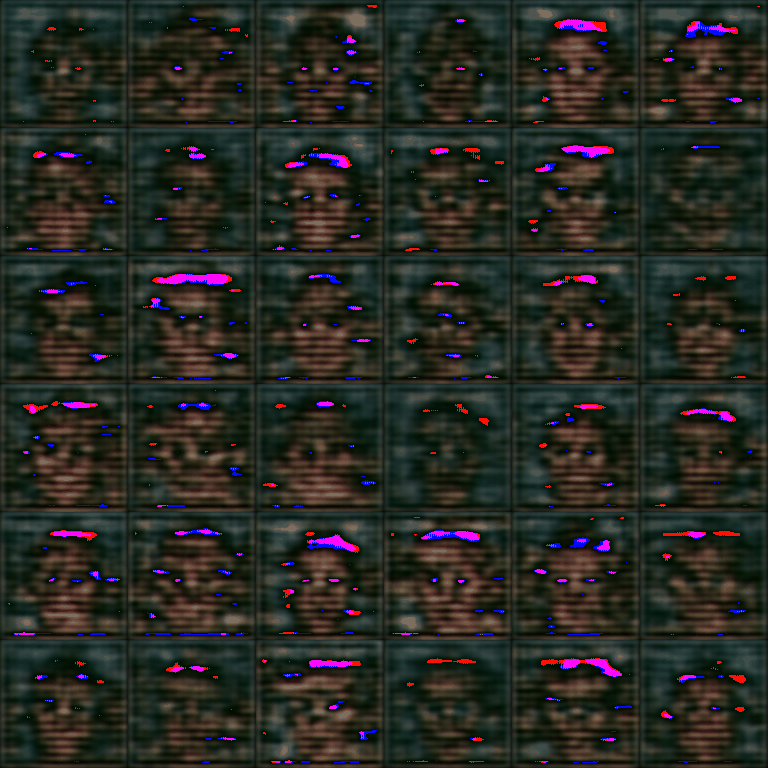

In [ ]:
from IPython.display import Image
#Image(url='https://upload.wikimedia.org/wikipedia/commons/e/e3/Animhorse.gif')
#But for a local file, you need to read the bytes and display it.

#!wget https://upload.wikimedia.org/wikipedia/commons/e/e3/Animhorse.gif
Image(open('/content/trainnig_visual.gif','rb').read())

In [ ]:
images_to_gif = []
for filename in os.listdir(RES_DIR):
    images_to_gif.append(imageio.imread(RES_DIR + '/' + filename))
imageio.mimsave('trainnig_visual.gif', images_to_gif)
shutil.rmtree(RES_DIR)

RuntimeError: ignored